In [2]:
import sys
sys.path.append('../')

import numpy as np
import cupy as cp
import opticaldevicelib_1d as od_1d
import matplotlib.pyplot as plt
# od_1d.OpticalDevice.init_values(new_dx=1e-9, new_Nx=2**20, gpu_use=True)
od_1d.OpticalDevice.init_values(new_dx=5e-8, new_Nx=2**10, gpu_use=True)
# od_1d.OpticalDevice.init_values(new_dx=5e-9, new_Nx=2**16, gpu_use=True)
# od_1d.OpticalDevice.init_values(new_dx=0.325e-6, new_Nx=2**10, gpu_use=True)
print(f"мера поля X = {od_1d.OpticalDevice.Nx * od_1d.OpticalDevice.dx * 1e6} мкм")

GPU is available!
мера поля X = 51.199999999999996 мкм


Оптическая схема с СПЛ с дефектами

In [2]:
"""Инициализация точечного источника"""
p = od_1d.PointSource(z=15, x0=0, En=12) 
E_ps1 = np.ones_like(p.E())

"""Параметры СПЛ"""
N_gl = 26
Copy_flag = True
A = 50e-6
R = 6.25e-6
d = 2e-6
mol = "Si"
dens = 2.33

"""Инициализация СПЛ"""
crl_ideal = od_1d.CRL(lam=p.lam, arr_start=E_ps1, z=0, R=R, A=A, d=d, N_lens=N_gl, mol=mol, dens=dens)

crl_m =  od_1d.CRLm(lam=p.lam, arr_start=E_ps1, z=0, R=6.25e-6, A=50e-6, d=2e-6, N_lens=26, mol='Si', dens=2.33,\
                     copy=Copy_flag, sigma=1.2e-6, height=0.1e-6, height_c=-0.35e-6, shift=3.2e-6)

focus = crl_ideal.focus()

print(f"фокусное расстояние = {focus * 1e3 :.3f} мм")


фокусное расстояние = 34.634 мм


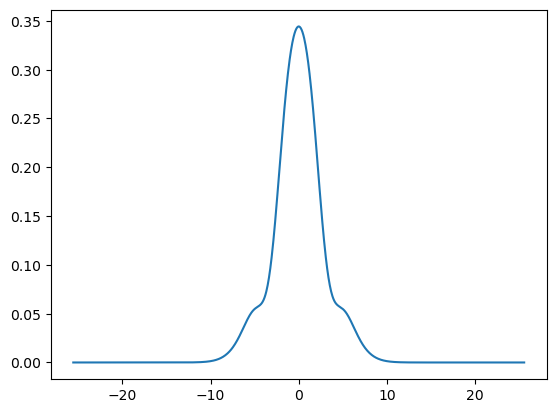

In [3]:
def gauss(x, A, mu, sig):
    return A*np.exp(-(x-mu)**2/(2*sig**2))

def shape_error(x, A_c, sig_c, A_s, sig_s, mu_s):
    return gauss(x, A_c, 0, sig_c) + gauss(x, A_s, mu_s, sig_s) + gauss(x, A_s, -mu_s, sig_s)    

xxx = p.x.get() * 1e6

# plt.plot(xxx, gauss(xxx, 0.3, 0, 0.3))

A_c = 0.35
A_s = -0.1
sig_c = 3
sig_s = 1.2
mu_s = 3.2

plt.plot(xxx, shape_error(xxx, A_c, sig_c, A_s, sig_s, mu_s))

(2500, 1024)


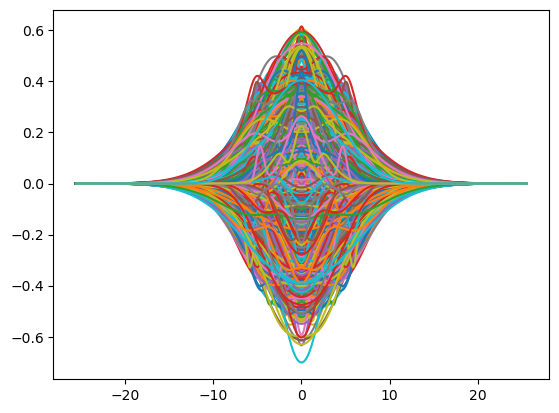

In [16]:
import numpy as np

def gauss(x, A, mu, sig):
    return A * np.exp(-(x - mu)**2 / (2 * sig**2))

def shape_error(x, A_c, sig_c, A_s, sig_s, mu_s):
    return gauss(x, A_c, 0, sig_c) + gauss(x, A_s, mu_s, sig_s) + gauss(x, A_s, -mu_s, sig_s)

def generate_patterns(x, num_patterns, distribution='u', seed=42):
    np.random.seed(seed)
    
    # Создаем пустой массив для хранения паттернов
    patterns = np.zeros((num_patterns, len(x)))
    coefs = np.zeros((num_patterns, 5))

    for i in range(num_patterns):
        if distribution == 'u':
            A_c = np.random.uniform(-0.4, 0.4)
            A_s = np.random.uniform(-0.2, 0.2)
            sig_c = np.random.uniform(0.5, 6)
            sig_s = np.random.uniform(0.25, 3)
            mu_s = np.random.uniform(1, 6)
        elif distribution == 'n':
            A_c = np.random.normal(0, 0.4)  # среднее 0, стандартное отклонение 0.5
            A_s = np.random.normal(0, 0.2)
            sig_c = np.random.normal(3.25, 2.75)
            sig_s = np.random.normal(1.625, 1.375)
            mu_s = np.random.normal(3.5, 3)
        else:
            raise ValueError("Unknown distribution type. Use 'u' for uniform or 'n' for normal.")

        # Записываем паттерн в массив
        patterns[i] = shape_error(x, A_c, sig_c, A_s, sig_s, mu_s)
        coefs[i] = np.array([A_c, sig_c, A_s, sig_s, mu_s])
    return patterns, coefs

N_patterns = 2500

# Пример использования
patterns, coefs = generate_patterns(xxx, N_patterns, distribution='u')

plt.plot(xxx, patterns.T)
print(patterns.shape)

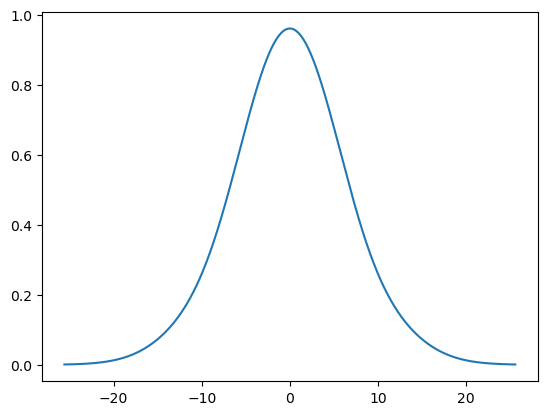

In [5]:
def coefs_to_shape_error(xxx, coefs):
    A_c, A_s, sig_c, sig_s, mu_s = coefs
    return shape_error(xxx, A_c, A_s, sig_c, sig_s, mu_s)


coefs_test = np.array([0.9901311, 6.80571, -0.09468901, 3.8582194, 7.494021]) 

plt.plot(xxx, coefs_to_shape_error(xxx, coefs_test))

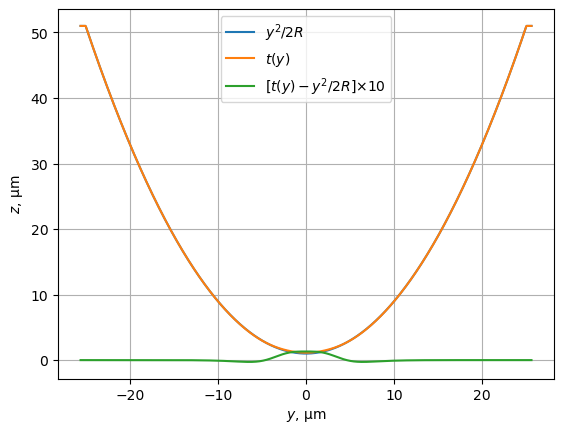

In [18]:
# %matplotlib widget
"""Построение профиля поверхности СПЛ"""
# I_prop = abs(crl.image_prop(z0=5, z1=focus, N_lens=N_gl)) ** 2
T_ideal = crl_ideal.T().get() * 1e6

T_m = T_ideal + patterns[0]


plt.plot(xxx, T_ideal, label=r"${y}^2/2R$")
plt.plot(xxx, T_m, label=r"$t(y)$")
# plt.plot(p.x.get()*1e6, arr_gauss*10, label='mult. by this gaussian')

plt.plot(xxx, (T_m - T_ideal)*10, label=r"$[t(y)-{y}^2/2R$]×10")
# plt.plot(xxx, -np.exp(-(xxx+4)**2/(2*(1.5)**2)))

# plt.plot(p.x.get()*1e6, dif_curv  , label="ellips")
# plt.plot(p.x.get()*1e6, , label="eq")
# plt.plot(p.x.get()*1e6, crl_curv.T().get(), label='ellips')
# plt.plot(p.x.get()*1e6, crl_eq.T().get(), label='equidist')
# plt.plot(p.x.get()*1e6, h.T().get(), label='equidist')
plt.legend()
# plt.yscale("log")
plt.xlabel("$y$, μm")
plt.ylabel("$z$, μm");
plt.grid()
# plt.ylim(-3, 10)
# plt.xlim(-10, 10);

 dz = 17.36620375251125 mm 
 dx = 0.0 μm 
 fwhm = 0.26796578714167635 μm 
 I_max = 30.97804958556648 rel. un. 
 div_ang = 0.0002864415826282496


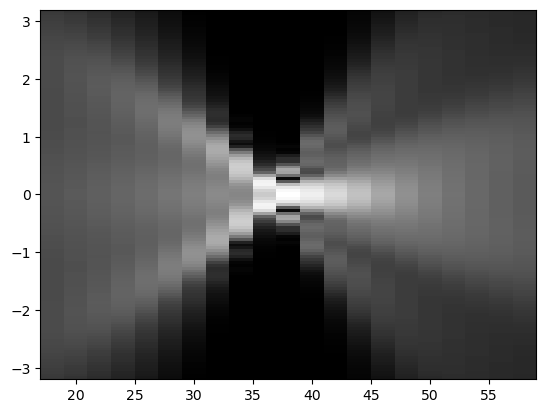

In [19]:
"""Точечный источник"""
z_arr = np.arange(16, 57, 2) * 1e-3
# z_arr = np.array([focus])
I_distr_max, I_max, dz_max_1, dx_max, fwhm, focus_images, z_arr, div_ang, x_cutted\
     = crl_m.focus_params(z_arr, T_arr=cp.array(T_m)*1e-6, n_cut=64, focus=34e-3)

print(f" dz = {(5e-2+dz_max_1*1e-3-crl_m.focus())*1e3} mm \n dx = {dx_max} μm \n fwhm = {fwhm*1e6} μm \n I_max = {I_max} rel. un. \n div_ang = {div_ang}")
I_sum_dot = abs(focus_images)**2
I_sum_dot = I_sum_dot.get()

plt.pcolormesh(z_arr*1e3+2, x_cutted*1e6, np.log1p(I_sum_dot.T), cmap="Greys_r")
# plt.ylim(-8, 10)
# plt.xticks(np.arange((z_arr*1e3+2)[0], (z_arr*1e3+2)[-1]+4, step=4))
# plt.yticks(np.arange(-8, 8+2, step=2));

In [20]:
"Протяженный источник"
crl_m.set_z(z=focus)
I_arr_test = crl_m.I()
z_arr = np.arange(16, 57, 2) * 1e-3

N_source_x = 21
size_source_x = cp.linspace(-2e-4, 2e-4, N_source_x)


def gauss_1d(x, sig):
    return np.exp(-0.5*(x/sig)**2)

gauss_test = cp.zeros(shape=(N_source_x))

sig = 1.17e-4 / 2.355

# sh1, sh2 = I_arr_test.shape
sh_z = len(z_arr)
I_sum = cp.zeros(shape=I_sum_dot.shape)
# I_sum_ideal = cp.zeros(shape=I_sum_dot.shape)

# phase_sum = cp.zeros(shape=(sh_z, int(20e-6/od_2d.OpticalDevice.dy)*2, int(20e-6/od_2d.OpticalDevice.dx)*2))
# phase_sum_ideal = cp.zeros(shape=(sh_z, int(20e-6/od_2d.OpticalDevice.dy)*2, int(20e-6/od_2d.OpticalDevice.dx)*2))

# t_loop = crl_global.T()


patterns = cp.array(patterns)
# t_loop = cp.array(T_ideal)

# N_frame = 8000

i_start = 0
i_end = N_patterns
I_data = cp.empty(shape=(i_end-i_start, len(z_arr), 128))

from tqdm import tqdm

for i in tqdm(range(i_start, i_end)):
    # print(f"---FRAME № {i}---")
    t_loop = (cp.array(T_ideal) + patterns[i]) * 1e-6
    I_sum = cp.zeros(shape=I_sum_dot.shape)
    for j, x0 in enumerate(size_source_x):
        p_loop = od_1d.PointSource(En=12, z=15, x0=x0)
        E_p_loop = p_loop.E()

        crl_loop = od_1d.CRLm(lam=p_loop.lam, arr_start=E_p_loop, z=0, R=6.25e-6, A=50e-6, d=2e-6, N_lens=26, mol='Si', dens=2.33,\
                        copy=Copy_flag, sigma=1.2e-6, height=0.1e-6, height_c=-0.35e-6, shift=3.2e-6)

        gauss_test[j] = gauss_1d(x0, sig)
            
        I_distr_max, I_max, dz_max_1, dx_max, fwhm, focus_images, z_arr, div_ang, x_cutted\
            = crl_loop.focus_params(z_arr, T_arr=t_loop, n_cut=64, focus=34e-3)
        
        I_sum += abs(focus_images)**2 * gauss_test[j] / N_source_x
    I_data[i-i_start] = I_sum
    

# cp.save("I_data", I_data)
# np.save("target_data", C)

    # I_distr_max, I_max, dz_max_1, dx_max, fwhm, focus_images, z_arr, div_ang, x_cutted\
    #     = crl_loop_ideal.focus_params(z_arr, n_cut=int(20e-6/od_1d.OpticalDevice.dx), focus=34e-3)
    # I_sum_ideal += abs(focus_images)**2 * gauss_test[j] / N_source_x

# I_sum = I_sum.get()
# I_sum_ideal = I_sum_ideal.get()

# print(I_sum.flatten().shape)

100%|██████████| 2500/2500 [54:01<00:00,  1.30s/it]


In [21]:
cp.save("I_gauss_err_data", I_data)
np.save("coefs_data", coefs)

In [ ]:
plt.pcolormesh(I_data[0].get())

In [ ]:
21*320

In [ ]:
plt.plot(size_source_x.get()*1e6, gauss_test.get())

In [ ]:
320*21

In [ ]:
plt.pcolormesh(z_arr*1e3, x_cutted*1e6, I_sum.T, cmap="CMRmap")
# plt.ylim(-10, 10)
plt.xticks(np.arange((z_arr*1e3)[0], (z_arr*1e3)[-1]+4, step=4))
# plt.yticks(np.arange(-8, 8+2, step=2));

In [ ]:
plt.plot(I_sum[9])

In [ ]:
from scipy.interpolate import interp1d

def interpolate_image(image, target_width):
  """
  Интерполирует изображение с ширины 1024 пикселей до target_width пикселей.

  Аргументы:
    image: numpy массив с формой (21, 1024), представляющий изображение.
    target_width: Целевая ширина изображения (в данном случае 256).

  Возвращает:
    numpy массив с формой (21, target_width), представляющий интерполированное изображение.
  """

  # Создаем массив x-координат для исходного изображения
  x = np.linspace(0, 1, image.shape[1])  # От 0 до 1, 1024 точки

  # Создаем массив x-координат для интерполированного изображения
  x_new = np.linspace(0, 1, target_width)  # От 0 до 1, target_width точки

  # Инициализируем массив для интерполированного изображения
  interpolated_image = np.zeros((image.shape[0], target_width))

  # Интерполируем каждую строку изображения
  for i in range(image.shape[0]):
    # Создаем функцию интерполяции для текущей строки
    f = interp1d(x, image[i, :], kind='linear')  # Линейная интерполяция

    # Интерполируем строку
    interpolated_image[i, :] = f(x_new)

  return interpolated_image

In [ ]:
plt.pcolormesh(interpolate_image(I_sum, 1024).T, cmap="CMRmap")
# plt.ylim(-10, 10)
# plt.xticks(np.arange((z_arr*1e3)[0], (z_arr*1e3)[-1]+4, step=4))
# plt.yticks(np.arange(-8, 8+2, step=2));